# Guide
## Data
[[Google Drive] /Data/Final/Step2-1.zip](https://drive.google.com/file/d/1KjVfu9UgvK0_tZtuOcJmaRCn44CtYxUq/view?usp=sharing)
## Code
In [3] `base_dir` : 실제 데이터 경로로 변경 필요

---

# Purpose
- 새로운 데이터 학습 결과 확인  
- Step1 최종 모델 적용  
[[Google Drive] /Code/Step1/9-3.Data_Added_SGD.ipynb](https://drive.google.com/file/d/1VDVs3Lc_BqxBOCRVwF-CbeA74BMa-Z3z/view?usp=sharing)

## Alternation
(compared to) `Step1/9-3.Data_Added_SGD` 모델  
- Data: Data_Initial/Step2-1 → Data_Final/Step2-1
- 2개의 클래스 분류 → 6개의 클래스 분류  
⇒ 마지막 layer의 노드 수, activation, 손실 함수 변경  
- `Conv2D(512)` layer 추가  
→ `BatchNormalization`, `ReLU`, `MaxPooling` layer 추가  
- `Dropout(0.25)` → `Dropout(0.3)`

In [1]:
from tensorflow import keras
from tensorflow.keras import layers, optimizers
import os

2024-11-24 10:27:55.306427: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
image_size = (400, 400)
batch_size = 32

### Data 변경

In [3]:
# 데이터셋 로드
from tensorflow.keras.utils import image_dataset_from_directory

# 실제 데이터의 경로로 변경 필요
base_dir = "/tf/Fixed_Data/Data_Final/Step2-1"   # Data_Final/Step1

train_dataset = image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=image_size,
    batch_size=batch_size)

validation_dataset = image_dataset_from_directory(
    os.path.join(base_dir, 'validation'),
    image_size=image_size,
    batch_size=batch_size)

test_dataset = image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=image_size,
    batch_size=batch_size)

Found 3780 files belonging to 6 classes.
Found 1080 files belonging to 6 classes.
Found 540 files belonging to 6 classes.


2024-11-24 10:27:56.749622: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-24 10:27:56.752851: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-24 10:27:56.752941: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### 모델 레이어 구성 변경

In [4]:
# 모델 레이어 구성
inputs = keras.Input(shape=(400, 400, 3))

x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32, kernel_size=3)(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
# x = layers.Dropout(0.25)(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# 추가
x = layers.Conv2D(filters=512, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation = "relu")(x)
x = layers.Dropout(0.3)(x)  # Dropout(0.25)

# outputs = layers.Dense(1, activation="sigmoid")(x)
outputs = layers.Dense(6, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 398, 398, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 398, 398, 32)      128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 398, 398, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 199, 199, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 197, 64)      18496 

### 손실함수 변경

In [6]:
# 학습률 및 옵티마이저 설정
optimizer = optimizers.SGD(learning_rate=1e-4, momentum=0.9)

# 모델 컴파일
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',   # loss='binary_crossentropy'
              metrics=['accuracy'])

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',       # 검증 손실을 기준으로 학습 중단
    patience=5,               # 성능이 개선되지 않는 에포크 수 (5회 연속 개선 없을 시 중단)
    restore_best_weights=True # 최적의 가중치 복원
)

In [8]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    callbacks=[early_stopping],
    batch_size=batch_size)

Epoch 1/100


2024-11-24 10:27:57.959355: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-24 10:27:58.541216: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-11-24 10:27:59.051468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-11-24 10:27:59.069596: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x8d297d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-24 10:27:59.069631: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-11-24 10:27:59.112375: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster

119/119 [==============================] - 16s 108ms/step - loss: 1.1053 - accuracy: 0.6153 - val_loss: 1.3354 - val_accuracy: 0.5398
Epoch 2/100
119/119 [==============================] - 12s 101ms/step - loss: 0.6028 - accuracy: 0.7706 - val_loss: 0.8907 - val_accuracy: 0.7019
Epoch 3/100
119/119 [==============================] - 12s 101ms/step - loss: 0.5095 - accuracy: 0.8140 - val_loss: 0.5311 - val_accuracy: 0.8417
Epoch 4/100
119/119 [==============================] - 12s 102ms/step - loss: 0.4130 - accuracy: 0.8487 - val_loss: 0.4985 - val_accuracy: 0.8380
Epoch 5/100
119/119 [==============================] - 12s 101ms/step - loss: 0.3478 - accuracy: 0.8728 - val_loss: 0.4705 - val_accuracy: 0.8417
Epoch 6/100
119/119 [==============================] - 12s 101ms/step - loss: 0.3289 - accuracy: 0.8839 - val_loss: 0.5095 - val_accuracy: 0.8278
Epoch 7/100
119/119 [==============================] - 12s 101ms/step - loss: 0.2817 - accuracy: 0.9032 - val_loss: 0.4598 - val_accurac

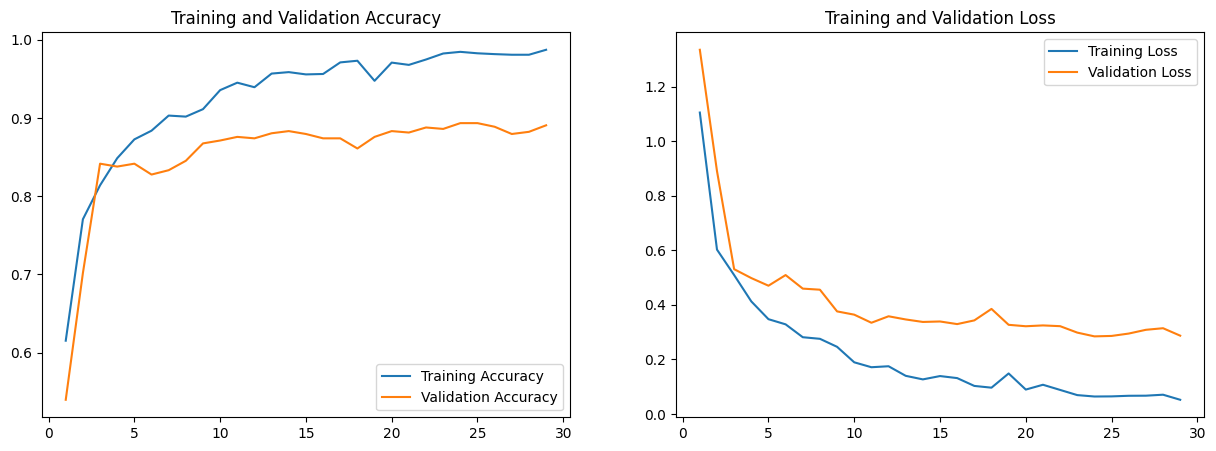

In [9]:
# 훈련 정확도와 손실 그래프 생성
import matplotlib.pyplot as plt 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

# Analysis - Training & Validation
## 과적합 
후반 Epoch에서 training과 validation 그래프의 차이가 큰 편  

---

In [10]:
test_loss, test_acc = model.evaluate(test_dataset)

print(f"test accuracy: {test_acc}")
print(f"test loss: {test_loss}")

17/17 [==============================] - 1s 59ms/step - loss: 0.2913 - accuracy: 0.8759
test accuracy: 0.8759258985519409
test loss: 0.2913450598716736


# Analysis - Test
(compared to) `Step1/9-3.Data_Added_SGD` 모델  
Accuracy : 93.9% → 87.6%  
Loss : 0.1712 → 0.2913  
클래스의 증가로 성능이 감소한 것으로 추측됨